In [1]:
using CairoMakie
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets, MultivariateStats;
using Measures: mm

include("final_analysis_library.jl");

In [6]:
#simulation params
L = 8
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

ncopies = 100
tini = 75
nsteps = 200
dt = 50

N = 128

lap = lap_hypercube(L)

folder = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/";
sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];

init="zeros/"

Xtr = get_muller_tot(folder*init,"saved_snaps/",ncopies,L,nsteps,tini,dt)./N
Ztr = get_muller_tot(folder*init,"saved_snaps_ref/",ncopies,L,nsteps,tini,dt)./N

Pmat = fit(PCA, Xtr; maxoutdim=3)
Y = predict(Pmat,Xtr);
Z = predict(Pmat,Ztr);
Y1, Y2, Y3 = Y[1,:], Y[2,:], Y[3,:]
Z1, Z2, Z3 = Z[1,:], Z[2,:], Z[3,:]
v1 = reshape(eigvecs(Pmat)[:,1],(1,2^L))

means = mean(fieldmatrix,dims=1)
dh = fieldmatrix .- means
cij = (dh' * dh)/M

F,V,G = get_FVG(means,cij,L,K)

reF = Float64.(reshape(F,(1,2^L)))
reV = Float64.(reshape(V,(1,2^L)))
reG = Float64.(reshape(G,(1,2^L)));

Gref_tr = (reG*Ztr)[1,:]

dr_F, dr_V, drift_pc1, drift_pc1_0, TF0, TF, TV0, TV, T_pc1, T_pc10, F_tr, V_tr, G_tr = proj_drift_diff(Xtr,reF,reV,reG,nu,lap,N,v1)
drift2 = get_dr2(reF, reV, Xtr, lap, N, nu)[:,1];

for init in append!(["ones/"],["rand$(i)/" for i in 1:5])
    print(init)
    Xtr = get_muller_tot(folder*init,"saved_snaps/",ncopies,L,nsteps,tini,dt)./N
    Ztr = get_muller_tot(folder*init,"saved_snaps_ref/",ncopies,L,nsteps,tini,dt)./N
    
    Y = predict(Pmat,Xtr)
    append!(Y1,Y[1,:])
    append!(Y2,Y[2,:])
    append!(Y3,Y[3,:])
    Z = predict(Pmat,Ztr);
    append!(Z1,Z[1,:])
    append!(Z2,Z[2,:])
    append!(Z3,Z[3,:])

    drf,drv,drpc1, drpc10,tf0,tf,tv0,tv,tpc1,tpc1_0,ftr,vtr,gtr = proj_drift_diff(Xtr,reF,reV,reG,nu,lap,N,v1) 
    append!(F_tr,ftr)
    append!(V_tr,vtr)
    append!(G_tr,gtr)
    gref= (reG*Ztr)[1,:]
    append!(Gref_tr,gref)
    
    append!(TF,tf)
    append!(TF0,tf0)
    append!(TV,tv)
    append!(TV0,tv0)
    append!(T_pc1,tpc1)
    append!(T_pc10,tpc1_0)
    append!(dr_F,drf)
    append!(dr_V,drv)
    append!(drift_pc1,drpc1)
    append!(drift_pc1_0,drpc10)
    
    append!(drift2,get_dr2(reF,reV,Xtr,lap,N,nu)[:,1])
end


idx = sortperm(abs.(drift2))[1:74970]
red_dr_F = dr_F[idx]
red_dr_V = dr_V[idx]
maxTF = maximum(abs.(red_dr_F))
maxTV = maximum(abs.(red_dr_V));


ones/rand1/rand2/rand3/rand4/rand5/

┌ Warning: `.px_area` got renamed to `.viewport`, and means the area the scene maps to in device independent units, not pixels. Note, `size(scene) == widths(scene.viewport[])`
└ @ Makie /Users/federica/.julia/packages/Makie/Y3ABD/src/deprecated.jl:17
┌ Warning: `.px_area` got renamed to `.viewport`, and means the area the scene maps to in device independent units, not pixels. Note, `size(scene) == widths(scene.viewport[])`
└ @ Makie /Users/federica/.julia/packages/Makie/Y3ABD/src/deprecated.jl:17


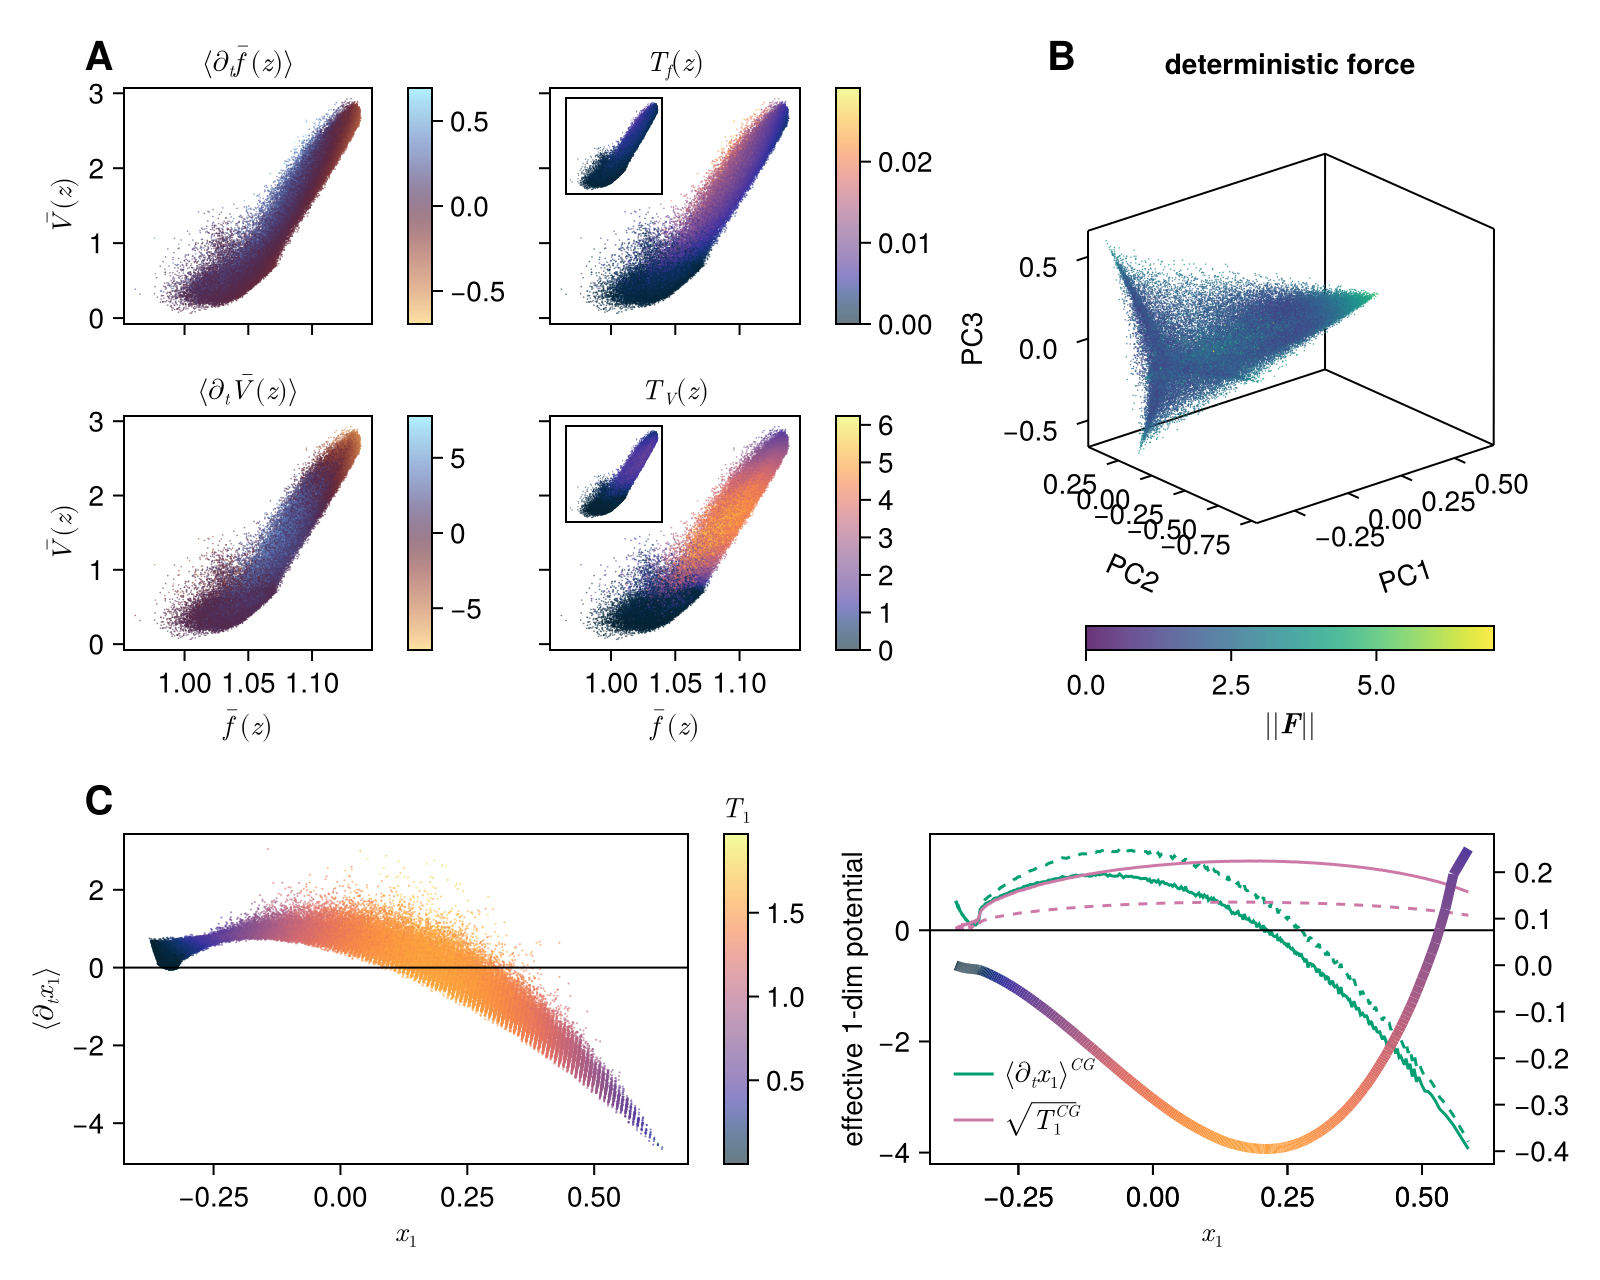

In [12]:
f = Figure(size = (800, 640))

f1 = f[1,1] = GridLayout()
f2 = f[1,2] = GridLayout()
gd = f[2, 1:2] = GridLayout()

#A
axbs = [Axis(f1[j, k], ygridvisible=false, xgridvisible=false) for j in 1:2, k in 1:4]
hidedecorations!.(axbs[1:2,2])
hidedecorations!.(axbs[1:2,4])
hidedecorations!(axbs[1,3],ticklabels = true, ticks=false)
hidexdecorations!(axbs[1,1],ticklabels = true, ticks=false)
hideydecorations!(axbs[2,3],ticklabels = true, ticks=false)

bbox1 = lift(axbs[1,3].scene.camera.projectionview, axbs[1,3].scene.px_area) do _, pxa
        p = Makie.project(axbs[1,3].scene, Point(1.02, 2.6))
        c = p + pxa.origin
        Rect2f(c .- Point2f(36, 36), (48, 48))
    end
axin1 = Axis(f, bbox = bbox1,xgridvisible = false,ygridvisible = false)
hidedecorations!(axin1)

bbox2 = lift(axbs[2,3].scene.camera.projectionview, axbs[2,3].scene.px_area) do _, pxa
        p = Makie.project(axbs[2,3].scene, Point(1.02, 2.6))
        c = p + pxa.origin
        Rect2f(c .- Point2f(36, 36), (48, 48))
    end
axin2 = Axis(f, bbox = bbox2,xgridvisible = false,ygridvisible = false)
hidedecorations!(axin2)

#B
ax1 = Axis3(f2[1,1], ygridvisible=false, xgridvisible=false, zgridvisible=false, protrusions=(60,10,0,-32),aspect = (1.2,1,0.9), ylabelvisible=true)
#hidespines!(ax1,:x)
#hidedecorations!(ax1)

#C
axds = [Axis(gd[1,i],xgridvisible = false,ygridvisible = false) for i in 1:3]
axtw = Axis(gd[1, 3], yaxisposition = :right, xgridvisible = false,ygridvisible = false)
hidedecorations!.(axds[2])



##########
# PANEL B
##########

sqdr2 = sqrt.(drift2)
S = scatter!(ax1, Y1, Y2, Y3, color = sqdr2, colormap=:viridis, markersize=1.1,alpha=0.8,colorrange=(0,0.85*maximum(sqdr2)))
ax1.xlabel = "PC1"
ax1.ylabel = "PC2"
ax1.zlabel = "PC3"
cb1 = Colorbar(f2[2,1],S,vertical=false,flipaxis=false,label=L"$|| \mathbf{F} ||$")

ax1.title="deterministic force"

##########
# PANEL A
##########

s1 = scatter!(axbs[1,1],F_tr[idx],V_tr[idx],color=red_dr_F,colormap=:managua,alpha=0.6,markersize=1.2,rasterize = true,
    colorrange=(-maxTF,maxTF))
s2 = scatter!(axbs[2,1],F_tr[idx],V_tr[idx],color=red_dr_V,colormap=:managua,alpha=0.6,markersize=1.2,rasterize = true,
    colorrange=(-maxTV,maxTV))

axbs[1,1].title = L"\langle \partial_t \bar{f}(z)\rangle"
axbs[2,1].title = L"\langle \partial_t \bar{V}(z)\rangle"

axbs[1,1].ylabel = L"\bar{V}(z)"
axbs[2,1].ylabel = L"\bar{V}(z)"
axbs[2,1].xlabel = L"\bar{f}(z)"
axbs[2,3].xlabel = L"\bar{f}(z)"

Colorbar(f1[1,2],s1)
Colorbar(f1[2,2],s2)

mTF = maximum(TF[idx])
mTV = maximum(TV[idx])
z1 = scatter!(axbs[1,3],F_tr[idx],V_tr[idx],color=TF[idx],colormap=:thermal,alpha=0.6,markersize=1.2,rasterize = true,
    colorrange=(0,mTF))
z2 = scatter!(axbs[2,3],F_tr[idx],V_tr[idx],color=TV[idx],colormap=:thermal,alpha=0.6,markersize=1.2,rasterize = true,
    colorrange=(0,mTV))

axbs[1,3].title = L"T_f(z)"
axbs[2,3].title = L"T_V(z)"

scatter!(axin1,F_tr[idx],V_tr[idx],color=TF0[idx],colormap=:thermal,alpha=0.6,markersize=1,rasterize = true, colorrange=(0,mTF))
scatter!(axin2,F_tr[idx],V_tr[idx],color=TV0[idx],colormap=:thermal,alpha=0.6,markersize=1,rasterize = true, colorrange=(0,mTV))

#axin1.title=L"T^0_f(z)"
#axin2.title=L"T^0_V(z)"

Colorbar(f1[1,4],z1)
Colorbar(f1[2,4],z2)



##########
# PANEL C
##########

p1 = scatter!(axds[1],Y1,drift_pc1;color=T_pc1,colormap=:thermal,alpha=0.6,markersize=1.5,rasterize = true)
cb = Colorbar(gd[1,2],p1)
axds[2].title=L"T_1"
hlines!(axds[1],[0],color=:black,linewidth=1)
axds[1].xlabel=L"x_1"
axds[1].ylabel=L"\langle\partial_t x_1\rangle"

#binning
Dr, Dr0, T, T0, Fx, Pot = extract_potential(Y1,drift_pc1,drift_pc1_0,T_pc1,T_pc10,200)
lines!(axds[3],Fx,Dr,label=L"\langle\partial_t x_1\rangle^{CG}",color=Makie.wong_colors()[3])
lines!(axds[3],Fx,Dr0,color=Makie.wong_colors()[3],linestyle=:dash)
lines!(axds[3],Fx,sqrt.(T),label=L"\sqrt{T_1^{CG}}",color=Makie.wong_colors()[4])
lines!(axds[3],Fx,sqrt.(T0),color=Makie.wong_colors()[4],linestyle=:dash)
axislegend(axds[3],position=:lb,framevisible=false)
hlines!(axds[3],[0],color=:black,linewidth=1)
axds[3].xlabel=L"x_1"
p2 = lines!(axtw,Fx, Pot,linewidth=5;color=Float64.(T),colorrange=(minimum(T_pc1),maximum(T_pc1)),colormap=:thermal)
axds[3].ylabel="effective 1-dim potential"

colsize!(f.layout, 1, Auto(1.8))
rowsize!(f.layout, 1, Auto(1.7))

for (label, layout) in zip(["A", "B", "C"], [f1, f2, gd])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 20,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end

save("../data/plots/fig3_ghost.pdf",f)
f